Three level lambda system. Strong coupling beam, weak probe beam, and microwave.

In [2]:
import numpy as np
import seaborn as sns
import qutip as qt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
#     Ladder:          Lambda:                 Vee:
#                                |three>=|e1>                 |three>
#       -------|three>           -------                      -------
#          |                       / \             |two>         /
#          |                      /   \           -------       /
#          |                     /     \             \         /
#       -------|two>            /       \             \       /
#          |                   /         \             \     /
#          |                  /           \             \   /
#          |                 /        --------           \ /
#       -------|one>      -------      |two>=|g2>      -------
#                         |one>=|g1>                   |one>
def GetNLevelBasis(numLevels):
    # use this to set basis in one line.
    lstKets = []
    for i in range(numLevels):
        lstKets.append(qt.basis(numLevels,i))
    return lstKets
    
def GetNLevelOperators(allKets):
    # use this to get transition operators in one line.
    lstOperators = []
    for ket in allKets:
        for i in range(len(allKets)):
            lstOperators.append(qt.tensor(ket*allKets[i].dag()))
    return lstOperators

def GetCollapseOperators(decayRates,transitionOperators):
    # use this to get dissipation operators in one line.
    lstCollapseOperators = []
    for i in range(len(decayRates)):
        lstCollapseOperators.append(np.sqrt(decayRates[i])*transitionOperators[i])
    return lstCollapseOperators

def NormalizeToMax(data,normFactor=1.0):
    """Normalizes a list to its maximum value.

    Args:
        data: A list of numerical values. normFactor: the value you want to normalize the values to.

    Returns:
        A new list with values normalized to the maximum value.
    """
    if not data:
        return []

    max_value = max(data)

    return [x *normFactor / max_value for x in data]
def FindMaxElement(matrix):
    """
    Finds the maximum element in a matrix.

    Args:
      matrix: A list of lists representing the matrix.

    Returns:
      The maximum element in the matrix, or None if the matrix is empty.
    """
    if not matrix:
        return None
    max_element = matrix[0][0]
    for row in matrix:
        for element in row:
            if element > max_element:
                max_element = element
    return max_element

In [4]:
class DeltaSystem():
    def __init__(self):
        self.absorptionValues = []
        self.dispersionValues = []
        self.susceptibility = pd.DataFrame()
        
        self.detuningCouple = 0
        self.detuningProbe = 0
        self.detuningMicrowave = 0
        self.detuningRange = 0
        self.numStepsDetuning = 0
        
        self.omegaProbe = 0 
        self.omegaCouple = 0
        self.omegaMicrowave = 0
        self.omegaMicrowaveList = []

        self.microwaveFrequency = 0

        self.decayRateProbe = 0
        self.decayRateCouple = 0
        self.decayRateMicrowave = 0

        self.decayRates = []
        self.collapseOperators = []
        self.basisSet = []
        self.h0 = qt.Qobj()
        self.h1 = qt.Qobj()
        self.h2 = qt.Qobj()
        self.h = qt.Qobj()
        
        self.rabiRatios = []
        self.microwaveDecayRates = []

        self.numTrajectories = 0
        self.timeSpan = []
        self.initialState = []
        self.singleTrajectory = []
        self.simulations = pd.DataFrame()
        self.output = []
        self.resolution = 0
        
    def PlotPopulationsLine(self):
                
        # Set variables necessary for calculations.
        self.decayRates = [self.decayRateProbe,self.decayRateCouple,self.decayRateMicrowave]
        
        # Get all the transition operators, but note that we won't use all of them.
        sig11,sig12,sig13,sig21,sig22,sig23,sig31,sig32,sig33 = GetNLevelOperators(self.basisSet)

        # Get the collapse operators. This is an open system with dissipation.
        c1,c2,c3 = GetCollapseOperators(self.decayRates,[sig13,sig23,sig12])
        self.collapseOperators = [c1,c2,c3]

        expectationValues = [sig11*sig11.dag(),sig22*sig22.dag(),sig33*sig33.dag()]

        self.SetHamiltonian()
        
        self.timeSpan = [time*self.decayRateProbe for time in self.timeSpan]
        
        self.output = qt.mesolve(self.h,self.initialState,self.timeSpan,self.collapseOperators,expectationValues)

        state1values = self.output.expect[0]
        state2values = self.output.expect[1]
        state3values = self.output.expect[2]

        self.Simulations = pd.DataFrame(list(zip(self.timeSpan,state1values,state2values,state3values)),columns=['time','state1','state2','state3'])
    
        numPlotRows =2
        numPlotCols = 2
        sns.set_palette("tab10") #default color palette.
        fig, axes = plt.subplots(numPlotRows, numPlotCols, figsize=(15, 15))

        trajectoryLabel = 'No RWA'

        sns.lineplot(ax=axes[0,0],data=self.Simulations,x="time",y="state3",color = 'skyblue',label=trajectoryLabel)
        sns.lineplot(ax=axes[1,0],data=self.Simulations,x="time",y="state1",color = 'skyblue',label=trajectoryLabel)
        sns.lineplot(ax=axes[1,1],data=self.Simulations,x="time",y="state2",color = 'skyblue',label=trajectoryLabel)
        
        sns.lineplot(ax=axes[0,1],data=self.Simulations,x="time",y="state1",label=r"$|C_{g1}|^{2}$ (No RWA)")
        sns.lineplot(ax=axes[0,1],data=self.Simulations,x="time",y="state2",label=r"$|C_{g2}|^{2}$ (No RWA)")
        sns.lineplot(ax=axes[0,1],data=self.Simulations,x="time",y="state3",label=r"$|C_{e1}|^{2}$ (No RWA)")
    
        axes[0,0].set_ylabel(r"$|C_{e1}|^{2}$")
        axes[1,0].set_ylabel(r"$|C_{g1}|^{2}$")
        axes[1,1].set_ylabel(r"$|C_{g2}|^{2}$")
        axes[0,1].set_ylabel("Probability")

        lenTrajectory = len(state1values)
        print("|g1> (probe) probability: " + str(round(state1values[lenTrajectory-1],3)))
        print("|g2> (couple) probability: " + str(round(state2values[lenTrajectory-1],3)))
        print("|e1> (excited) probability: " + str(round(state3values[lenTrajectory-1],3)))
        
        '''
        Now plot without RWA approximation.
        '''
        self.output = qt.mesolve(self.h0,self.initialState,self.timeSpan,self.collapseOperators,expectationValues)

        state1values = self.output.expect[0]
        state2values = self.output.expect[1]
        state3values = self.output.expect[2]

        self.Simulations = pd.DataFrame(list(zip(self.timeSpan,state1values,state2values,state3values)),columns=['time','state1','state2','state3'])

        trajectoryLabel = 'Using RWA'

        sns.lineplot(ax=axes[0,0],data=self.Simulations,x="time",y="state3",color='darkblue',lw=1,ls='--',label=trajectoryLabel)
        sns.lineplot(ax=axes[1,0],data=self.Simulations,x="time",y="state1",color='darkblue',lw=1,ls='--',label=trajectoryLabel)
        sns.lineplot(ax=axes[1,1],data=self.Simulations,x="time",y="state2",color='darkblue',lw=1,ls='--',label=trajectoryLabel)

        '''
        x-axis labels and legend stuff.
        '''
        for i in range(numPlotRows):
            for j in range(numPlotCols):
                axes[i,j].set_xlabel(r"$\gamma_{13}{t}$")
                axes[i,j].legend(loc='best')
                axes[i,j].margins(x=0)     
        plt.show()  
        
    def H1_coeff(self,t,args):
        return np.exp(1j*2*self.microwaveFrequency*t)
    def H2_coeff(self,t,args):
        return np.exp(-1j*2*self.microwaveFrequency*t)
    def SetHamiltonian(self):
        self.h0 = 0.5*qt.Qobj([[0,self.omegaMicrowave,self.omegaProbe],
            [self.omegaMicrowave,2*(self.detuningProbe-self.detuningCouple-self.detuningMicrowave),self.omegaCouple],
            [self.omegaProbe,self.omegaCouple,2*self.detuningProbe]])
        self.h1 = 0.5*qt.Qobj([[0,self.omegaMicrowave,0],
            [0,0,0],
            [0,0,0]])
        self.h2 = 0.5*qt.Qobj([[0,0,0],
            [self.omegaMicrowave,0,0],
            [0,0,0]])
        self.h = [self.h0,[self.h1,self.H1_coeff],[self.h2,self.H2_coeff]]
    def PlotPopulationsColor(self):
                
        # Set variables necessary for calculations.
        self.decayRates = [self.decayRateProbe,self.decayRateCouple,self.decayRateMicrowave]
        
        # Get all the transition operators, but note that we won't use all of them.
        sig11,sig12,sig13,sig21,sig22,sig23,sig31,sig32,sig33 = GetNLevelOperators(self.basisSet)

        # Get the collapse operators. This is an open system with dissipation.
        c1,c2,c3 = GetCollapseOperators(self.decayRates,[sig13,sig23,sig12])
        self.collapseOperators = [c1,c2,c3]

        expectationValues = [sig11*sig11.dag(),sig22*sig22.dag(),sig33*sig33.dag()]
        
        self.timeSpan = [time*self.decayRateProbe for time in self.timeSpan]

        zValuesState1 = np.empty((self.resolution,self.resolution))
        zValuesState2 = np.empty((self.resolution,self.resolution))
        zValuesState3 = np.empty((self.resolution,self.resolution))

        intZLoop =0
        for omegaMicrowave in self.omegaMicrowaveList:
            self.omegaMicrowave = omegaMicrowave
            self.SetHamiltonian()
            self.output = qt.mesolve(self.h0,self.initialState,self.timeSpan,self.collapseOperators,expectationValues)
            zValuesState1[intZLoop] = self.output.expect[0]
            zValuesState2[intZLoop] = self.output.expect[1]
            zValuesState3[intZLoop] = self.output.expect[2]
            intZLoop+=1

        
        fig, axes = plt.subplots(3,1,figsize=(11,18))
        X,Y = np.meshgrid(self.timeSpan,self.omegaMicrowaveList)

        Z = zValuesState3
        c1=axes[0].pcolor(X, Y, Z, cmap='viridis',vmin=np.min(Z),vmax=np.max(Z))
        fig.colorbar(c1, ax=axes[0],label=r"$|C_{e1}|^{2}$")
        
        Z = zValuesState2
        c2=axes[1].pcolor(X, Y, Z, cmap='viridis',vmin=np.min(Z),vmax=np.max(Z))
        fig.colorbar(c2, ax=axes[1],label=r"$|C_{g2}|^{2}$")
        
        Z = zValuesState1
        c3=axes[2].pcolor(X, Y, Z, cmap='viridis',vmin=np.min(Z),vmax=np.max(Z))
        fig.colorbar(c3, ax=axes[2],label=r"$|C_{g1}|^{2}$")
        
        for i in range(3):
            axes[i].set_xlabel(r"$\gamma_{13}{t}$")
            axes[i].set_ylabel(r"$\Omega_{m}$")
        plt.tight_layout()
        plt.show()

T:\Users\thomas\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


|g1> (probe) probability: 0.963
|g2> (couple) probability: 0.018
|e1> (excited) probability: 0.019


T:\Users\thomas\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


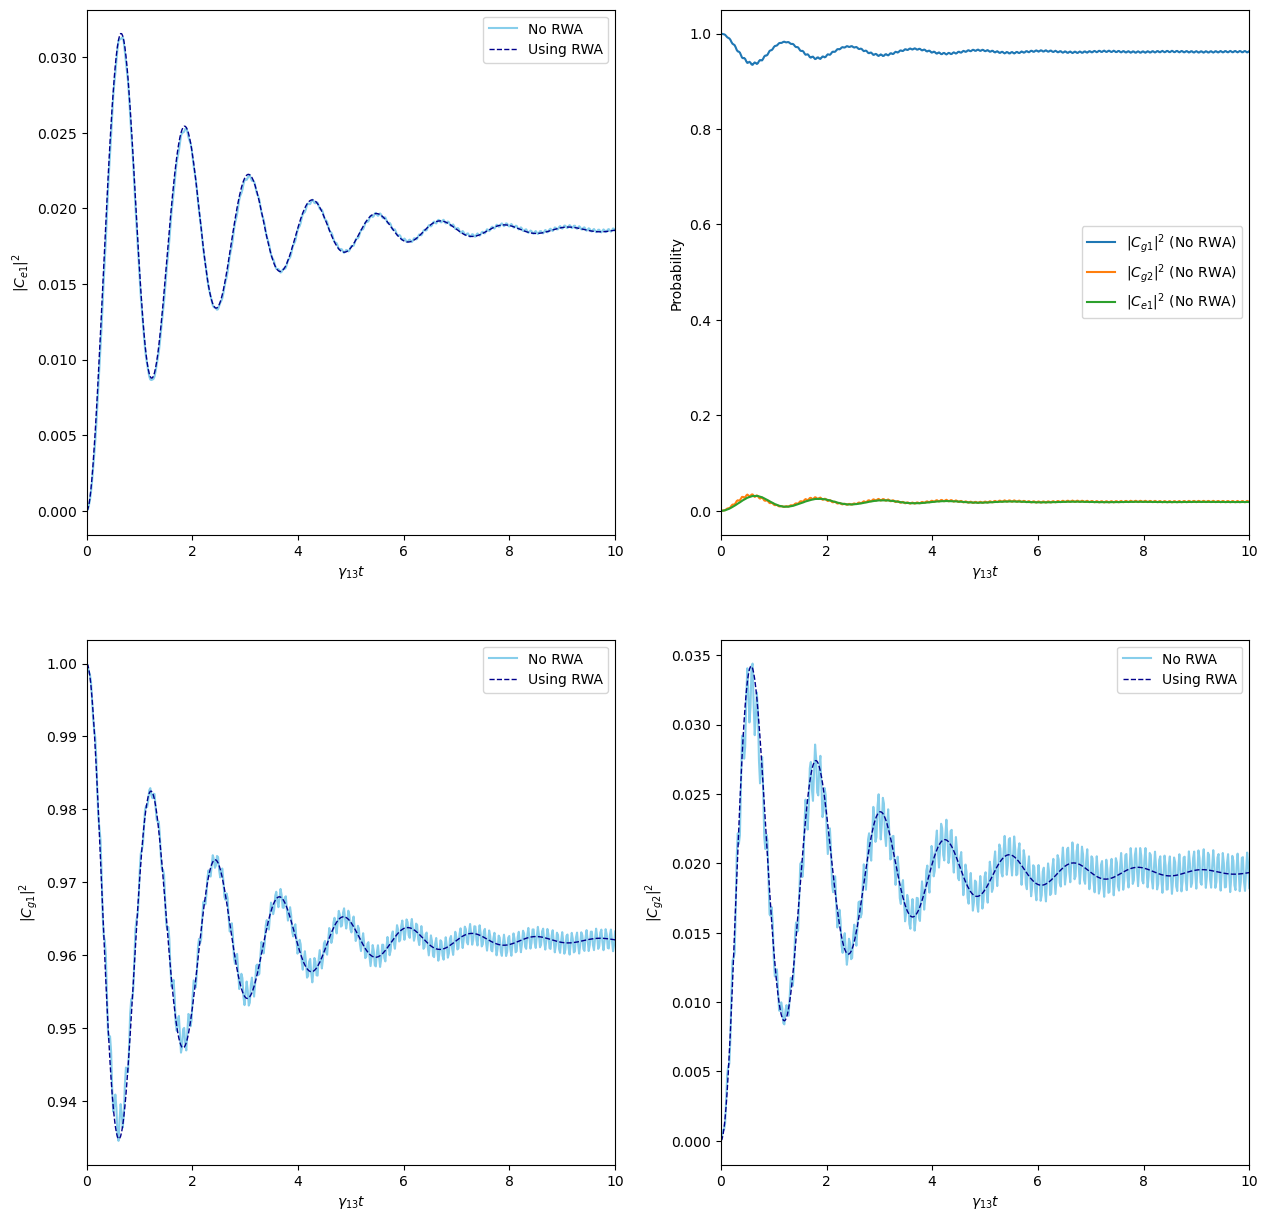

In [5]:
threeLevel = DeltaSystem()

threeLevel.numTrajectories = 500
threeLevel.timeSpan = np.linspace(0,10,500)
threeLevel.basisSet = GetNLevelBasis(3)    # Lambda system. level 3 is excited state.
threeLevel.initialState = threeLevel.basisSet[0] # index 0 = ground for probe, 1 = ground for couple, 2 = excited.

threeLevel.decayRateProbe = 1 # 3 -> 1 transition rate
threeLevel.decayRateCouple = 1 # 3 -> 2 transition rate
threeLevel.decayRateMicrowave = .007388 # 2 -> 1 transition rate
    
threeLevel.omegaProbe = 1    # Rabi frequency for probe beam. This beam is generally weaker than coupling beam.
threeLevel.omegaCouple = 10 # coupling beam is stronger than probe beam.
threeLevel.omegaMicrowave = 1
threeLevel.microwaveFrequency = 34.2063

threeLevel.detuningCouple = 0.0   
threeLevel.detuningProbe = 0.0 
threeLevel.detuningMicrowave = 0.0

threeLevel.PlotPopulationsLine()

T:\Users\thomas\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


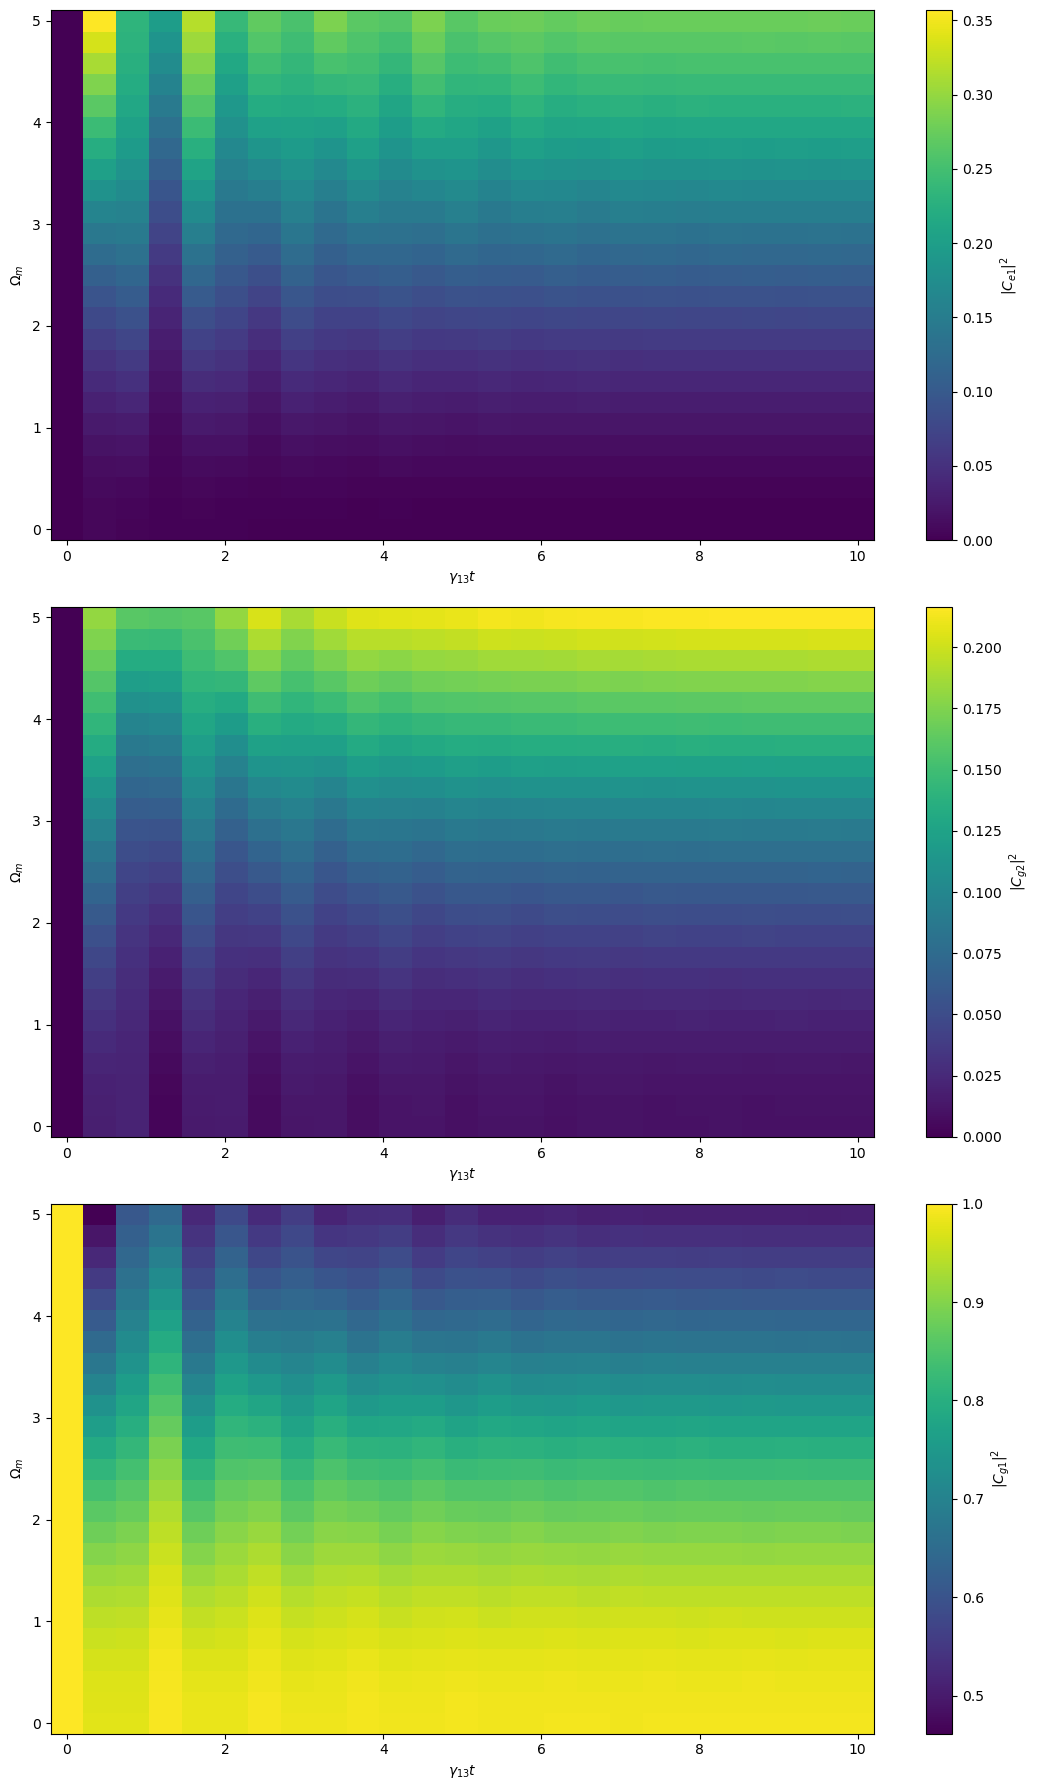

In [6]:
threeLevel = DeltaSystem()
'''

'''
threeLevel.resolution = 25
threeLevel.numTrajectories = 500
threeLevel.timeSpan = np.linspace(0,10,threeLevel.resolution)
threeLevel.basisSet = GetNLevelBasis(3)    # Lambda system. level 3 is excited state.
threeLevel.initialState = threeLevel.basisSet[0] # index 0 = ground for probe, 1 = ground for couple, 2 = excited.
'''
These are properties of the system. Varying these values gives insights to EIT behavior.
'''
#   Decay rates.
threeLevel.decayRateProbe = 1 # 3 -> 1 transition rate
threeLevel.decayRateCouple = 1 # 3 -> 2 transition rate
threeLevel.decayRateMicrowave = .007388 # 2 -> 1 transition rate
    
threeLevel.omegaProbe = 1    # Rabi frequency for probe beam. This beam is generally weaker than coupling beam.
threeLevel.omegaCouple = 10 # coupling beam is stronger than probe beam.
threeLevel.omegaMicrowaveList = np.linspace(0,5,threeLevel.resolution)
threeLevel.microwaveFrequency = 34.2063

threeLevel.detuningCouple = 0.0   
threeLevel.detuningProbe = 0.0 
threeLevel.detuningMicrowave = 0.0

threeLevel.PlotPopulationsColor() #note using RWA